In [8]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from astropy.stats import sigma_clip
from scipy.stats import iqr

from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as u
from copy import deepcopy

from multiprocessing import Pool
import emcee
from sigmacut import calcaverageclass

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

corrections = np.loadtxt('ps1_calspec_cor.txt')
calsources = pd.read_csv('../calibration/calspec_full.csv')

In [9]:
syn = np.load('current_caspec_mags.npy',allow_pickle=True).item()
syn = pd.DataFrame(syn)

good = []
for i in range(len(syn['name'])):
    if 'ngc6681' not in syn['name'].iloc[i]:
        good += [i]
good = np.array(good)
syn = syn.iloc[good]
gr = syn['g'].values-syn['r'].values
ind = (gr < 1) #& (gr >= 0.2)
syn = syn.iloc[ind]
calmed = Calmed[good][ind]

In [10]:
def mag2flux(mag,zp=25):
    flux = 10**(-1/2.5*(mag-zp))
    return flux
    

def k_comp(c,mag,ext=None,zp=25):
    if ext is not None:
        ge = ext * 3.629#3.518 # 
        re = ext * 2.611#2.617 # 
        ie = ext * 1.935#1.971 # 
        ze = ext * 1.523#1.549 # 
        ke = ext * 2.557
    else:
        ge = 0
        ie = 0
        ze = 0
        re = 0
        ke = 0
    g = mag2flux(mag['g']-ge,zp)
    r = mag2flux(mag['r']-re,zp)
    i = mag2flux(mag['i']-ie,zp)
    z = mag2flux(mag['z']-ze,zp)
    #old
    #fit = c[0]*g + c[1]*r + c[2]*i + c[3]*z + c[4]*(g-r)
    #new
    fit = -2.5*np.log10((c[0]*g + c[1]*r + c[2]*i + c[3]*z)*(g/i)**c[4]) + zp
    fit += ke
    return fit 

def k_minimizer(c,mag,ext=None):
    k = mag['kep']
    fit = k_comp(c,mag,ext)
    diff = abs(k-fit)
    res = np.nansum(diff)
    #print(res)
    return res

In [25]:
c0 = [.259,0.498,0.177,0.068,0.033]
c0 = [.1,.1,.1,.1,1]
bds = [(0,2),(0,2),(0,2),(0,2),(-100,100)]
res = minimize(k_minimizer,c0,args=(syn),bounds=bds)

/Users/rridden/miniconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/rridden/miniconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [26]:
res

      fun: 0.1406557135217099
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([11.6006099 ,  7.18699056,  5.03555402,  8.25757578, 11.83996173])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1032
      nit: 53
     njev: 172
   status: 0
  success: True
        x: array([0.1949156 , 0.47633709, 0.2555733 , 0.0761279 , 0.09312286])

In [27]:
test = k_comp(res.x,syn)
#test = r_comp(mc,syn)
kdiff = syn['kep']-test
gr = syn['g'].values-syn['r'].values
mask = ~sigma_clip(kdiff).mask
kdiff = kdiff[mask]

<IPython.core.display.Javascript object>


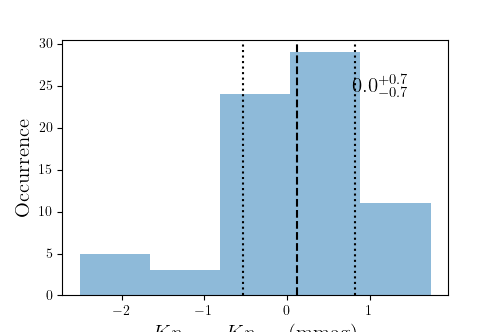

Text(0, 0.5, 'Occurrence')

In [28]:
plt.figure(figsize=(1.5*fig_width,1*fig_width))
b = int(np.nanmax(kdiff) - np.nanmin(kdiff) /(2*iqr(kdiff)*len(kdiff)**(-1/3)))
plt.hist(kdiff*1e3,bins=5,alpha=0.5)
#plt.hist(control[mask]*1e3)
#plt.hist(kdiff[ind],bins=10)
med = np.percentile(kdiff*1e3,50)
low = np.percentile(kdiff*1e3,16)
high = np.percentile(kdiff*1e3,84)
plt.axvline(med,ls='--',color='k')
plt.axvline(low,ls=':',color='k')
plt.axvline(high,ls=':',color='k')

s = '$'+str((np.round(med,0)))+'^{+' + str((np.round(high-med,1)))+'}_{'+str((np.round(low-med,1)))+'}$'
plt.annotate(s,(.75,.8),fontsize=15,xycoords='axes fraction')

plt.xlabel(r'$Kp_{cal}-Kp_{com}$ (mmag)',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
#plt.savefig('PS1_com_kep_res.pdf', bbox_inches = "tight")

<IPython.core.display.Javascript object>


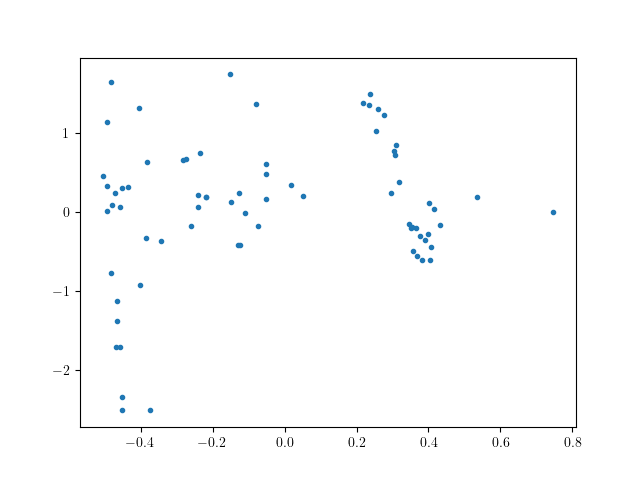

In [32]:
plt.figure()
plt.plot(gr[mask],kdiff*1e3,'.')

In [102]:
np.nansum((kdiff)**2/np.std(kdiff)**2)/len(test)

0.924969395319366

# error prop

In [3]:
data = pd.read_csv('K2_all_PS1_psc_ev_crowding_sdss2.csv')
data['kMeanPSFMagErr'] = (2.5 / np.log(10)) * (data['PDCe'].values / data['PDC'].values)
diff = abs(data['rMeanPSFMag'].values - data['crMeanPSFMag'].values)
ind = diff < .1

data = data.iloc[ind]

ind = ((abs(data['zMeanPSFMagErr'].values) < 0.5) & 
       (abs(data['gMeanPSFMagErr'].values) < 0.5) & 
       (abs(data['rMeanPSFMagErr'].values) < 0.5) & 
       (abs(data['iMeanPSFMagErr'].values) < 0.5))
data = data.iloc[ind]
ind = (data['gMeanPSFMag'].values-data['rMeanPSFMag'].values) < .8
data = data.iloc[ind]

ind = (data['ps_score'].values) > .95
data = data.iloc[ind]


In [121]:
def flux_error(mag,magerr,zp=25):
    flux = 10**(-1/2.5*(mag-zp))
    
    flux_err = flux * magerr*np.log(10)/2.5
    return flux, flux_err

def mag_error(flux,fluxerr,zp=25):
    mag = -2.5 * np.log10(flux) + zp
    mag_err = (2.5 / np.log(10)) * (fluxerr / flux)
    return mag, mag_err

def Kcom_error(data,zp=25,ext=0):
    
    ex_g = 3.62895124*ext; ex_r = 2.61050894*ext; ex_i=1.93460086*ext
    ex_z = 1.52472518*ext; ex_k = 2.55730023*ext
    
    g,ge = flux_error(data['gMeanPSFMag'].values-ex_g,data['gMeanPSFMagErr'].values,zp)
    r,re = flux_error(data['rMeanPSFMag'].values-ex_r,data['rMeanPSFMagErr'].values,zp)
    i,ie = flux_error(data['iMeanPSFMag'].values-ex_i,data['iMeanPSFMagErr'].values,zp)
    z,ze = flux_error(data['zMeanPSFMag'].values-ex_z,data['zMeanPSFMagErr'].values,zp)
    
    
    a = 0.25867244; b = 0.49876061; c = 0.17878655; 
    d = 0.06411439; e = 0.01929574
    u = a*g + b*r + c*i + d*z
    dkdg = a*(g/i)**e + e/i*u*(g/i)**(e-1)
    dkdi = c*(g/i)**e - e*g**e/i**(e+1) * u
    dkdr = b*(g/i)**e 
    dkdz = d*(g/i)**e 
    var = dkdg**2 * ge**2 + dkdr**2*re**2 + dkdi**2*ie**2 + dkdz**2*ze**2
    error = np.sqrt(var)
    flux = (a*g + b*r + c*i + d*z)*(g/i)**e
    mag, magerr = mag_error(flux,error)
    mag += ex_k
    return mag, magerr


In [122]:
ext = np.load('output/extinctions.npy')
camp = data['campaign'].values
chan = data['Channel'].values
medall = ext[camp,chan-1]

In [123]:
mag, err = Kcom_error(data,ext=medall)

<IPython.core.display.Javascript object>


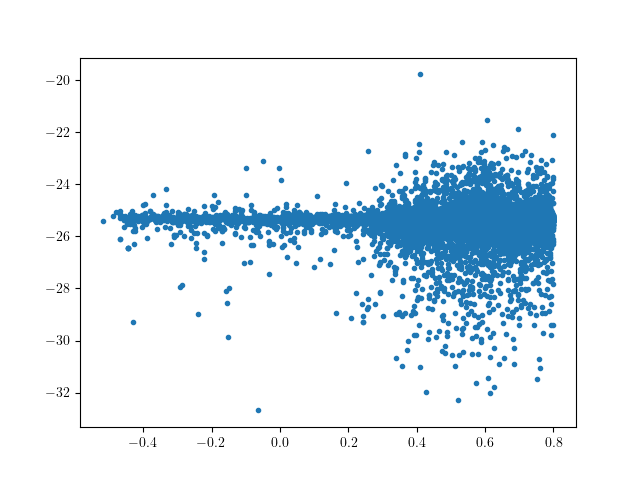

<ErrorbarContainer object of 3 artists>

In [124]:
x = (data['gMeanPSFMag']- data['rMeanPSFMag']).values
plt.figure()
plt.errorbar(x,data['kMeanPSFMag'].values-mag,yerr=(np.sqrt(err**2)),fmt='.')
#plt.ylim(-24,-26)

In [125]:
z = np.zeros([20,84])*np.nan
ze = np.zeros([20,84])*np.nan
zps = mag-data['kMeanPSFMag'].values
zperr = np.sqrt(err**2 + data['kMeanPSFMagErr'].values**2)

for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        ind = ((data['Channel'].values == j) & (data['campaign']==i) & 
               (data['gMeanPSFMag'].values - data['rMeanPSFMag'].values < .8)&
               np.isfinite(zps))
        if len(zps[ind]) > 0:
            sig = calcaverageclass()
            sig.calcaverage_sigmacutloop(zps[ind],noise=zperr[ind],Nsigma=5,saveused=True)
            #print('C',i,' ',sum(~sig.clipped))
            if sum(~sig.clipped) > 10:
                #clip = ~sigma_clip(zps[ind]).mask
                z[i,j] =  sig.mean#np.nanmedian(zps[ind][clip])
                ze[i,j] = sig.mean_err#np.nanstd(zps[ind][clip])

In [130]:
np.isfinite(z)

array([[False, False, False, ...,  True,  True, False],
       [False,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False,  True,  True],
       ...,
       [False,  True, False, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False]])

In [133]:
bad = np.nansum(np.isfinite(z)*1,axis=1) <10

<IPython.core.display.Javascript object>


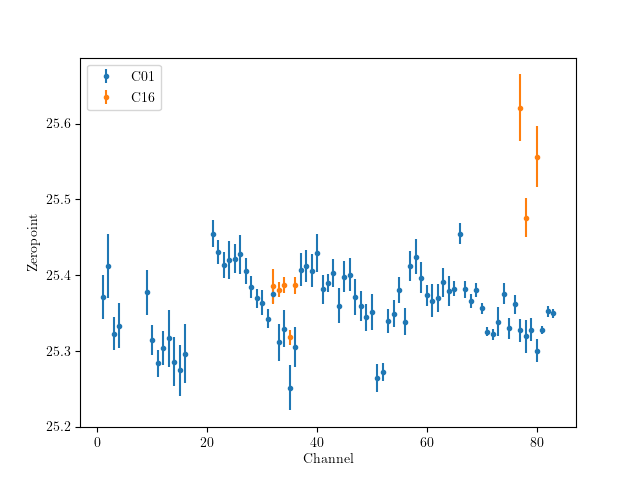

Text(0.5, 0, 'Channel')

In [129]:
x = np.arange(84)
plt.figure()
plt.errorbar(x,z[1],yerr=ze[1],fmt='.',label='C01')
#plt.errorbar(x,z[6],yerr=ze[6],fmt='.',label='C06')
plt.errorbar(x,z[7],yerr=ze[7],fmt='.',label='C16')
plt.legend()
#plt.ylim(25.1,25.5)
plt.ylabel('Zeropoint')
plt.xlabel('Channel')
#plt.savefig('zeropoints.png')

In [411]:
np.save('output/kep_com_zp.npy',z)

In [334]:
ind = ~np.isfinite(z) | ~np.isfinite(1/ze)
z[ind] = 0
ze[ind] = 10000

eh = np.average(z,weights=1/ze,axis=0)

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [365]:
z[:,60]

array([25.39073485, 25.37307015,         nan, 25.3737285 , 25.35040912,
       25.36374351, 25.37719256,         nan, 25.36540033,         nan,
               nan,         nan, 25.34989456, 25.3706052 , 25.34763103,
       25.36084472, 25.34607645, 25.33831225, 25.31763386,         nan])

In [102]:
av = []
ave = []
for i in range(z.shape[1]):
    sig = calcaverageclass()
    ind = np.isfinite(z[:,i])
    sig.calcaverage_sigmacutloop(z[ind,i],noise=ze[ind,i],Nsigma=10,median_firstiteration=True,saveused=True)
    av += [sig.mean]
    ave += [sig.mean_err]
    
av = np.array(av)
ave = np.array(ave)

In [19]:
av

array([None, 25.320811337538228, 25.36324461389977, 25.19323071385963,
       25.25434880525618, None, None, None, None, 25.367146568397676,
       25.32375092793428, 25.248049936471965, 25.267680701749406,
       25.291846455745677, 25.25874809384716, 25.261657111652642,
       25.2488567187083, None, None, None, None, 25.431320592116315,
       25.407894707131998, 25.393808487423673, 25.40769312486949,
       25.400794702591977, 25.40857025597762, 25.38092234715814,
       25.361205941130827, 25.33008870512715, 25.32686897936352,
       25.268858412318416, 25.26556679497551, 25.286746753451983,
       25.31912460350292, 25.2467322509426, 25.2877709910225,
       25.387759044789295, 25.38772799463103, 25.37552107376088,
       25.383349077431763, 25.350007984536617, 25.364581282515125,
       25.374506484578834, 25.344199265793506, 25.366671023430523,
       25.362708434141673, 25.34538149552467, 25.333205753721423,
       25.318252182779904, 25.32900871019632, 25.22891265884112,
    

<IPython.core.display.Javascript object>


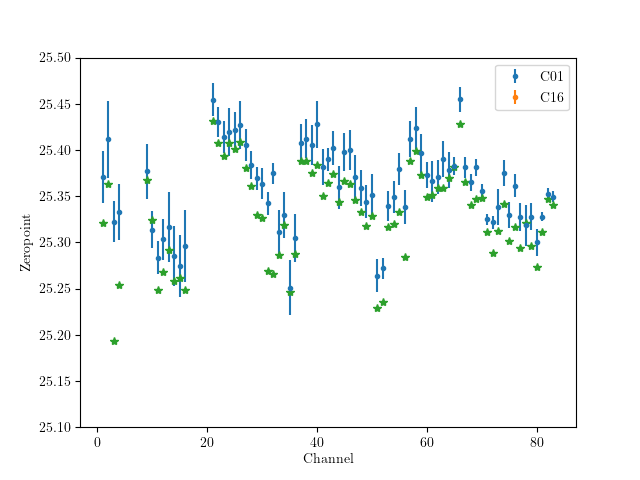

/Users/rridden/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


In [20]:
x = np.arange(84)
plt.figure()
plt.errorbar(x,z[1],yerr=ze[1],fmt='.',label='C01')
#plt.errorbar(x,z[6],yerr=ze[6],fmt='.',label='C06')
plt.errorbar(x,z[11],yerr=ze[11],fmt='.',label='C16')
plt.plot(x,av,'*')
plt.legend()
plt.ylim(25.1,25.5)
plt.ylabel('Zeropoint')
plt.xlabel('Channel')
plt.savefig('zeropoints.png')

In [313]:
1/ze

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[1.00000000e-10, 1.93651547e+01, 1.00000000e-10, ...,
        1.85044818e+01, 1.51511312e+01, 9.01191655e+00],
       [1.00000000e-10, 9.12352031e+01, 2.25994120e+02, ...,
        6.03392585e+01, 7.15423201e+01, 6.64484930e+01],
       [1.00000000e-10, 1.00000000e-10, 1.78271034e+02, ...,
                   inf, 2.26122491e+01, 3.37977212e+01],
       ...,
       [1.00000000e-10, 4.16420770e+00,            inf, ...,
        4.04575883e+01, 4.27374032e+01, 5.66591645e+01],
       [1.00000000e-10, 1.11639781e+01, 2.20053504e+01, ...,
        2.99455522e+01, 3.67293641e+01, 2.15784396e+01],
       [1.00000000e-10, 1.00000000e-10, 1.00000000e-10, ...,
        1.00000000e-10, 1.00000000e-10, 1.00000000e-10]])

In [134]:
decay = []
decaye = []
for i in range(len(z)):
    sig = calcaverageclass()
    ind = np.isfinite(z[1,:]-z[i,:])
    n = np.sqrt(ze[1,ind]**2 + ze[i,ind]**2)
    sig.calcaverage_sigmacutloop(z[1,ind]-z[i,ind],noise=n,Nsigma=10,median_firstiteration=True,saveused=True)
    if sig.mean is None:
        decay += [np.nan]
        decaye += [np.nan]
    else:
        decay += [sig.mean]
        decaye += [sig.mean_err]
decay = -np.array(decay) * 1e3
decaye = np.array(decaye) * 1e3
decay[bad] = np.nan

In [135]:
from astropy.modeling import models, fitting
from astropy.time import Time
fields = np.loadtxt('../kepler/k2_end_times.txt',delimiter='\t',dtype=object)
times = []
for i in range(len(fields)):
    times += [Time(fields[i,1]).mjd]
times = np.array(times)
times = times[1:]
times -= times[1]

In [136]:
x = np.arange(len(decay))
ind = np.isfinite(decay) & np.isfinite(decaye)
fit = fitting.LinearLSQFitter()
# initialize a linear model
line_init = models.Linear1D()
# fit the data with the fitter
fitted_line = fit(line_init, times[ind], decay[ind],weights=1/(decaye[ind]+1e-3))

In [106]:
from matplotlib.ticker import MaxNLocator

In [139]:
np.where(bad)

(array([ 0,  2,  3,  4,  7,  9, 10, 11, 19]),)

<IPython.core.display.Javascript object>


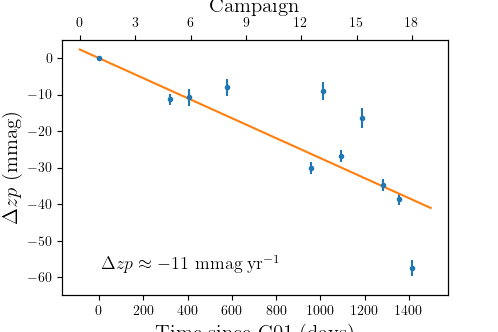

Text(0.5, 0, 'Campaign')

In [137]:
plt.figure(figsize=(1.5*fig_width,1*fig_width))
plt.errorbar(times,decay,yerr=decaye,fmt='.')
plt.plot(times,fitted_line(times))
plt.xlabel('Time since C01 (days)',fontsize=15)
plt.ylabel('$\Delta zp$ (mmag)',fontsize=15)
plt.annotate(r'$\Delta zp \approx -11\rm~mmag\;yr^{-1}$',(.1,.1),fontsize=13,xycoords='axes fraction')
plt.ylim(-65,5)

ax2 = plt.gca().twiny()
plt.plot(x,alpha=0)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Campaign',fontsize=15)
#plt.savefig('zp_time_evolution.pdf', bbox_inches = "tight")

In [142]:
fitted_line

<Linear1D(slope=-0.02740821, intercept=0.0000012)>

In [144]:
0.02740821*365

10.00399665

In [90]:
ave

array([None, 0.0009321270508651113, 0.0006529108114789032,
       0.0051723966895832, 0.0008244869751427498, None, None, None, None,
       0.006474902828267472, 0.006588661222757699, 0.0010549306242332716,
       0.0008109815854811183, 0.00038371607686389474,
       0.0004866813903080202, 0.0006720086248885325,
       0.0007279273006074618, None, None, None, None,
       0.0003534846976755691, 0.00026270938545048015,
       0.0005186018470279292, 0.00040358485998171547,
       0.0003881068935361534, 0.0005172231301459005,
       0.0003969885871116366, 0.0004973467272618583,
       0.0006414647432857237, 0.0005503839559997747,
       0.0018646459027142931, 0.0007835895167528981, 0.000630914293621757,
       0.0004959416819302563, 0.0006412199641336066,
       0.0005691368305017648, 0.00035637388871024423,
       0.00031536818932891036, 0.00040595594819735,
       0.00037729835202511504, 0.00027384144107091155,
       0.0002746890015216974, 0.00024603633631140016,
       0.0004839982874

<IPython.core.display.Javascript object>


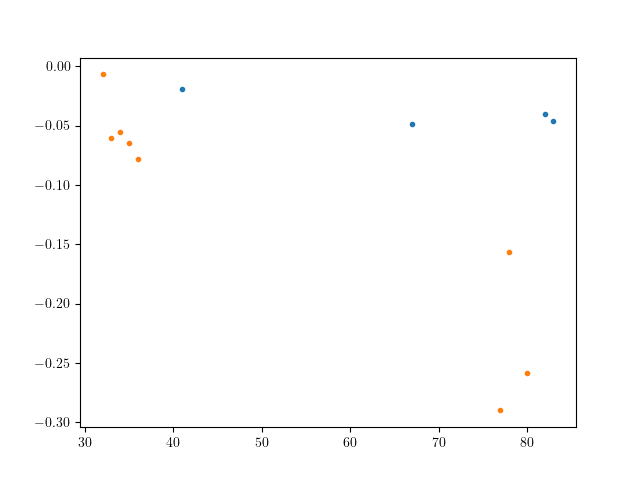

In [427]:
plt.figure()
plt.plot(z[1]-z[2],'.')
plt.plot(z[1]-z[7],'.')

0.02581940945245975

<IPython.core.display.Javascript object>


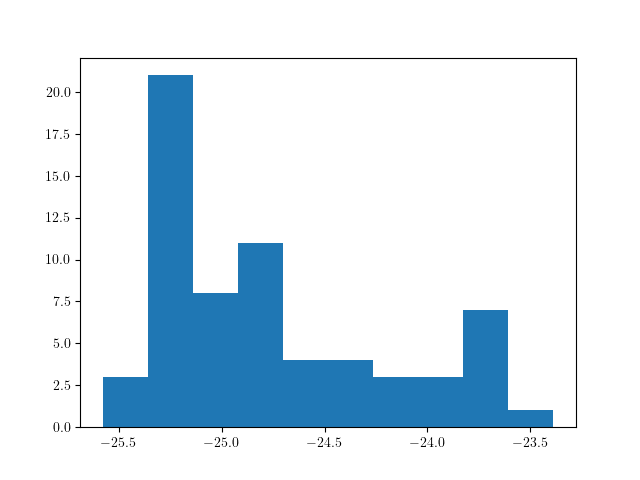

(array([ 3., 21.,  8., 11.,  4.,  4.,  3.,  3.,  7.,  1.]),
 array([-25.57918215, -25.35996846, -25.14075477, -24.92154108,
        -24.70232739, -24.48311371, -24.26390002, -24.04468633,
        -23.82547264, -23.60625895, -23.38704526]),
 <BarContainer object of 10 artists>)

In [201]:
ind = ((data['Channel'].values == 31) & (data['campaign']==16) & 
       (data['gMeanPSFMag'].values - data['rMeanPSFMag'].values < .8) &
      (data['gMeanPSFMag'].values - data['rMeanPSFMag'].values > .2))
if len(zps[ind]) > 0:
    clip = ~sigma_clip(zps[ind]).mask
    z += [-np.nanmedian(zps[ind][clip])]
    ze += [np.nanstd(zps[ind][clip])]

plt.figure()
plt.hist(zps[ind][clip])

In [191]:
np.nanmedian(zps[ind][clip])

-25.362858870661533

In [192]:
np.nanstd(zps[ind][clip])

0.010116617640140385

<IPython.core.display.Javascript object>


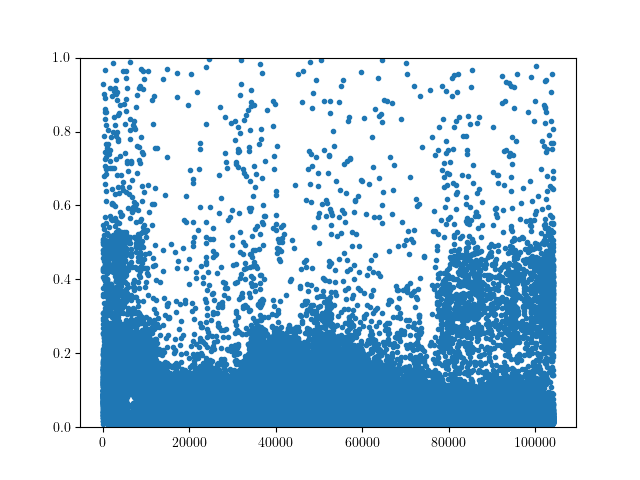

(0.0, 1.0)

In [150]:
plt.figure()
plt.plot(data['kMeanPSFMagErr'],'.')
plt.ylim(0,1)

In [133]:
max(err)

0.006262495305252064

In [ ]:
def mag2flux(mag,zp=25):
    flux = 10**(-1/2.5*(mag-zp))
    return flux